In [ ]:
#https://blog.dominodatalab.com/topology-and-density-based-clustering/
#https://app.dominodatalab.com/u/LeJit/Clustering/browse?

In [1]:
import numpy as np
from scipy.spatial.distance import cdist

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
%pylab inline
sns.set()

Populating the interactive namespace from numpy and matplotlib


#Epsilon-Balls

In [4]:
test_pt = np.array([3,2])
datapoints = 1.5*(np.random.rand(100,2)-0.5)+test_pt

In [5]:
def compute_balls(data, epsilon = 0.5):
    circle = np.linspace(0, 2*np.pi, 100)
    neighborhood = []
    data_x, data_y = data
    #Create a circle of radius epsilon
    for direction in circle:
        x_pos = data_x + epsilon*np.cos(direction)
        y_pos = data_y + epsilon*np.sin(direction)
        neighborhood.append((x_pos,y_pos))
    return neighborhood

In [6]:
neighborhood = compute_balls(test_pt, epsilon = 0.15)

In [7]:
X,Y = zip(*neighborhood)
X,Y = np.array(X),np.array(Y)

In [9]:
count = len(filter(lambda x: x < 0.15, cdist(datapoints, test_pt.reshape(1,2))))

TypeError: object of type 'filter' has no len()

Text(0.5,1,'Density-Reachable with radius 0.15')

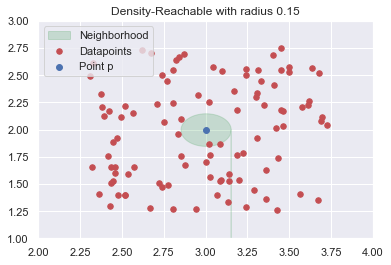

In [10]:
plt.fill_between(X, Y, alpha = 0.25, color = 'g', label = "Neighborhood")
plt.scatter(datapoints[:,0], datapoints[:,1], s = 30, color = 'r',label = "Datapoints")
plt.scatter(test_pt[0],test_pt[1], s = 35, label = "Point p")
plt.xlim(2,4)
plt.ylim(1,3)
plt.legend(loc = 2)
plt.title("Density-Reachable with radius 0.15")
#plt.savefig("results/neighborhood_reachable_base.png", format="PNG")

#DBSCAN - Wholesale

In [11]:
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans

In [12]:
from sklearn.preprocessing import StandardScaler
import pandas as pd

In [15]:
data = pd.read_csv("wholesale.csv")
data.drop(["Channel", "Region"], axis = 1, inplace = True)

In [16]:
data.head(5)

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,12669,9656,7561,214,2674,1338
1,7057,9810,9568,1762,3293,1776
2,6353,8808,7684,2405,3516,7844
3,13265,1196,4221,6404,507,1788
4,22615,5410,7198,3915,1777,5185


In [17]:
data = data[["Grocery", "Milk"]]
data = data.as_matrix().astype("float32", copy = False)

AttributeError: 'DataFrame' object has no attribute 'as_matrix'

In [18]:
stscaler = StandardScaler().fit(data)
data = stscaler.transform(data)

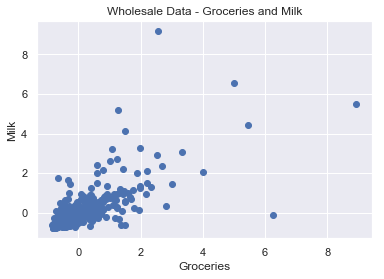

In [20]:
plt.scatter(data[:,0], data[:,1])
plt.xlabel("Groceries")
plt.ylabel("Milk")
plt.title("Wholesale Data - Groceries and Milk")
plt.savefig("wholesale.png", format = "PNG")

In [21]:
dbsc = DBSCAN(eps = .5, min_samples = 15).fit(data)

In [22]:
labels = dbsc.labels_
core_samples = np.zeros_like(labels, dtype = bool)
core_samples[dbsc.core_sample_indices_] = True

In [23]:
unique_labels = np.unique(labels)
colors = plt.cm.Spectral(np.linspace(0,1, len(unique_labels)))

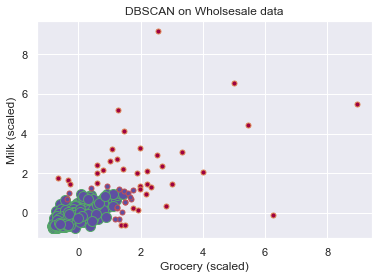

In [24]:
for (label, color) in zip(unique_labels, colors):
    class_member_mask = (labels == label)
    xy = data[class_member_mask & core_samples]
    plt.plot(xy[:,0],xy[:,1], 'o', markerfacecolor = color, markersize = 10)
    
    xy2 = data[class_member_mask & ~core_samples]
    plt.plot(xy2[:,0],xy2[:,1], 'o', markerfacecolor = color, markersize = 5)
plt.title("DBSCAN on Wholsesale data")
plt.xlabel("Grocery (scaled)")
plt.ylabel("Milk (scaled)")
plt.savefig("dbscan_wholesale.png", format = "PNG")

In [25]:
kmeans = KMeans(n_clusters = 2).fit(data)
labels_kmeans = kmeans.labels_
centroids = kmeans.cluster_centers_

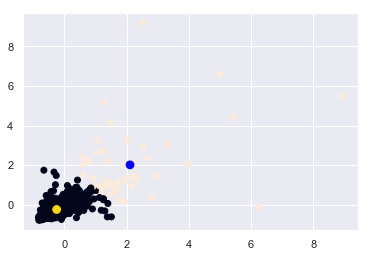

In [27]:
plt.scatter(data[:,0], data[:,1], c = labels_kmeans)
plt.scatter(centroids[:,0], centroids[:,1], c = ["gold","blue"], s = 60 )
plt.savefig("kmeans_wholesale.png", format = "PNG")

#DBSCAN - Half Moons

In [28]:
from sklearn.datasets import make_moons
#moons_X: Data, moon_y: Labels
moons_X, moon_y = make_moons(n_samples = 2000)

In [29]:
def add_noise(X,y, noise_level = 0.01):
    #The number of points we wish to make noisy
    amt_noise = int(noise_level*len(y))
    #Pick amt_noise points at random
    idx = np.random.choice(len(X), size = amt_noise)
    #Add random noise to these selected points
    noise = np.random.random((amt_noise, 2) ) -0.5
    X[idx,:] += noise
    return X    

In [30]:
moon_noise_X = add_noise(moons_X, moon_y)

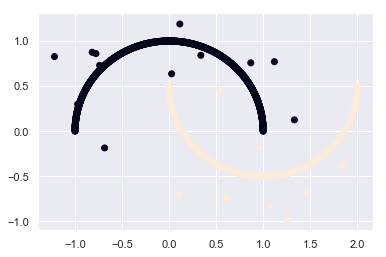

In [31]:
plt.scatter(moon_noise_X[:,0], moon_noise_X[:,1], c = moon_y)
plt.savefig("rmoons_noise.png", format = "PNG")

In [32]:
dbsc = DBSCAN(eps = 0.05, min_samples = 10).fit(moon_noise_X)
#Get the cluster labels
labels = dbsc.labels_
#Identify the core and border points
core_samples = np.zeros_like(labels, dtype = bool)
core_samples[dbsc.core_sample_indices_] = True

In [33]:
unique_labels = np.unique(labels)
colors = ["red", "gold", "silver"]

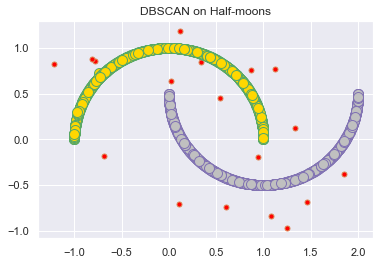

In [35]:
for (label, color) in zip(unique_labels, colors):
    class_member_mask = (labels == label)
    xy = moon_noise_X[class_member_mask & core_samples]
    plt.plot(xy[:,0],xy[:,1], 'o', markerfacecolor = color, markersize = 10)
    
    xy2 = moon_noise_X[class_member_mask & ~core_samples]
    plt.plot(xy2[:,0],xy2[:,1], 'o', markerfacecolor = color, markersize = 5)
plt.title("DBSCAN on Half-moons")
plt.savefig("dbscan_moons.png", format = "PNG")

In [36]:
kmeans_moons = KMeans(n_clusters = 2).fit(moon_noise_X)
labels = kmeans_moons.labels_

In [37]:
unique_labels = np.unique(labels)
colors = ["gold", "silver"]

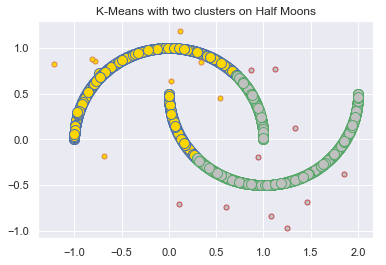

In [38]:
for (label, color) in zip(unique_labels, colors):
    class_member_mask = (labels == label)
    xy = moon_noise_X[class_member_mask & core_samples]
    plt.plot(xy[:,0],xy[:,1], 'o', markerfacecolor = color, markersize = 10)
    
    xy2 = moon_noise_X[class_member_mask & ~core_samples]
    plt.plot(xy2[:,0],xy2[:,1], 'o', markerfacecolor = color, markersize = 5)
plt.title("K-Means with two clusters on Half Moons")
plt.savefig("kmeans_moons.png", format = "PNG")

#Level Set Trees

In [39]:
def makeCraters(inner_rad = 4, outer_rad = 4.5, donut_len = 2, inner_pts = 1000, outer_pts = 500):
    #Make the inner core
    radius_core = inner_rad*np.random.random(inner_pts)
    direction_core = 2*np.pi*np.random.random(size = inner_pts)
    #Simulate inner core points
    core_x = radius_core*np.cos(direction_core)
    core_y = radius_core*np.sin(direction_core)
    crater_core = zip(core_x, core_y)
    #Make the outer ring
    radius_ring = outer_rad + donut_len*np.random.random(outer_pts)
    direction_ring = 2*np.pi*np.random.random(size = outer_pts)
    #Simulate ring points
    ring_x = radius_ring*np.cos(direction_ring)
    ring_y = radius_ring*np.sin(direction_ring)
    crater_ring = zip(ring_x, ring_y)
    
    return np.array(crater_core), np.array(crater_ring)

In [40]:
crater_core, crater_ring = makeCraters(inner_pts = 2000, outer_pts = 1000)

In [41]:
plt.scatter(crater_core[:,0], crater_core[:,1], c = "red")
plt.scatter(crater_ring[:,0], crater_ring[:,1], c = "blue")
plt.rc('font', family='sans-serif') 
plt.title("Crater Dataset")
plt.savefig("crater_data.png", format = "PNG")

IndexError: too many indices for array

In [19]:
def knn_estimate(data, k, point):
    n,d = data.shape
    #Reshape the datapoint, so the cdist function will work
    point = point.reshape((1,2))
    #Find the distance to the kth nearest data point
    knn = sorted(reduce(lambda x,y: x+y,cdist(data, point).tolist()))[k+1]
    #Compute the density estimate using the mathematical formula
    estimate = float(k)/(n*np.power(knn, d)*np.pi)
    return estimate

In [20]:
full_crater = np.vstack((crater_core, crater_ring))

In [21]:
knn_density = np.array([knn_estimate(full_crater, 500, point) for point in full_crater])

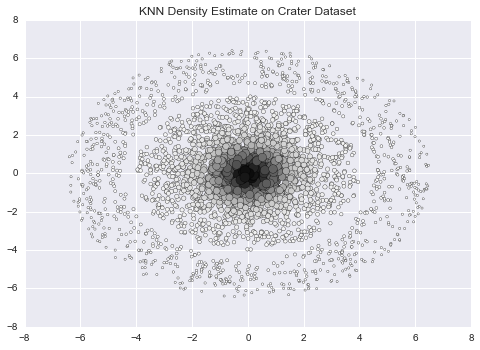

In [23]:
plt.scatter(full_crater[:,0], full_crater[:,1], s = knn_density*2000, c = knn_density*1000)
plt.title("KNN Density Estimate on Crater Dataset")
plt.savefig("results/knn_density.png", format = "PNG")

#Application

In [8]:
from debacl import geom_tree as gtree
from debacl import utils as utl

In [19]:
n,p = full_crater.shape

In [20]:
n_samples = 1000
ix = np.random.choice(range(n), size = n_samples, replace = False)
data = full_crater[ix,:]
n,p = full_crater.shape

In [44]:
p_k = 0.005
p_gamma = 0.0075

In [45]:
k = int(p_k*n)
gamma = int(p_gamma*n)
#utl.setPlotParams(axes_labelsize = 28, xtick_labelsize = 20, ytick_labelsize = 20, figsize = (8,8))

In [46]:
tree = gtree.geomTree(data, k, gamma, n_grid = None, verbose = False)
print tree

     alpha1  alpha2  children   lambda1   lambda2 parent  size
key                                                           
0     0.000   0.200    [3, 4]  0.000000  0.004437   None  1000
3     0.200   0.301  [15, 16]  0.004437  0.005855      0   744
4     0.200   0.676        []  0.004437  0.016344      0    36
15    0.301   1.000        []  0.005855  0.789812      3   621
16    0.301   0.646        []  0.005855  0.014754      3    24


In [47]:
uc, nodes = tree.getClusterLabels(method = "all-mode")

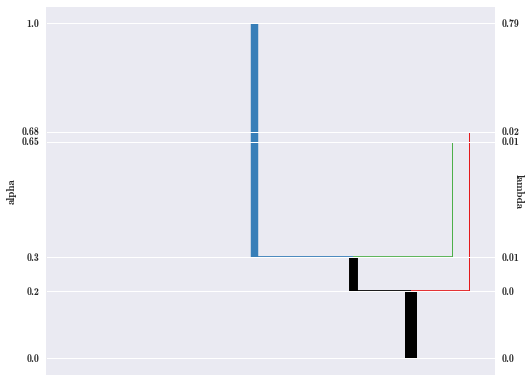

In [54]:
fig = tree.plot(form = 'alpha', width = 'mass', color_nodes = nodes)[0]
fig.savefig("results/lstree.png", format = "PNG")

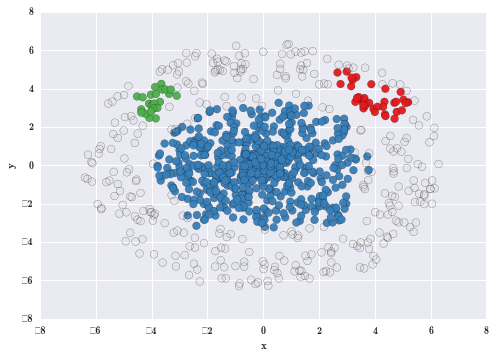

In [55]:
fig, ax = utl.plotForeground(data, uc, fg_alpha = 0.95, bg_alpha = 0.1, edge_alpha = 0.6, s = 60)
fig.savefig("results/lst_allmode.png", format = "PNG")

#Level Sets

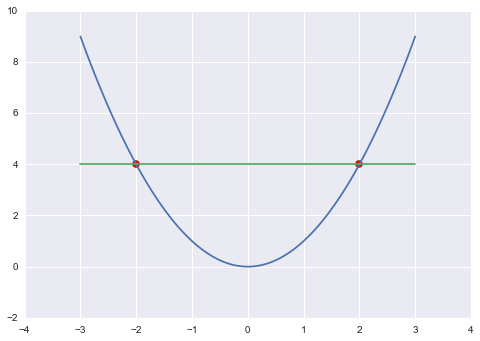

In [198]:
x_pts = np.linspace(-3,3, 100)
y_pts = x_pts ** 2
plt.plot(x_pts, y_pts)
plt.plot(x_pts, [4]*len(x_pts))
plt.scatter([-2,2],[4,4], c = "red", s = 50)
plt.savefig("results/levelset.png", format="PNG")

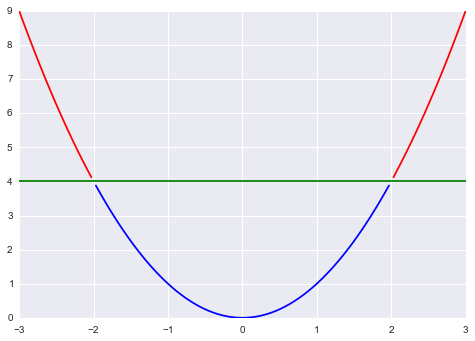

In [197]:
index = 17
plt.plot(x_pts[:17], y_pts[:17], color = "red")
plt.plot(x_pts[100-17:], y_pts[100-17:], color = "red")
plt.plot(x_pts[17:100-17], y_pts[17:100-17], color = "blue")
plt.plot(x_pts, [4]*len(x_pts), color = "green")
plt.savefig("results/upperlevelset.png", format="PNG")